In [1]:
# Pouya Ghaemmaghami
# coding: utf-8

# In[89]:


# import necessary packages:
import pandas as pd
import numpy as np
import scipy
import math
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
from pandas import datetime
import math
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
#import pandas_datareader.data as web
from scipy import stats
import helpers as hp

Using TensorFlow backend.


In [2]:
!pwd

/scratch/home/g.koehler/test_keras/BrainhackNetworks_indicators_restingstate/codes


In [3]:
# load the fMRI data:
subject_label   = 100307
day_num         = 1
fmri_path       = '/scratch/home/g.koehler/test_keras/BrainhackNetworks_indicators_restingstate/datasets/fMRI/'
df              = pd.read_csv(fmri_path + '/day' + str(day_num) + '/' + str(subject_label) + '.csv',header=None)
data            = df.values
Nvars           = data.shape[1]
labels_Glasser  = pd.read_csv(fmri_path + 'labels_Glasser.csv',header=None)[0].tolist()
df.columns      = labels_Glasser
TR              = 0.72 #[s]

In [4]:
print(labels_Glasser)

['V1', 'MST', 'V6', 'V2', 'V3', 'V4', 'V8', '4', '3b', 'FEF', 'PEF', '55b', 'V3A', 'RSC', 'POS2', 'V7', 'IPS1', 'FFC', 'V3B', 'LO1', 'LO2', 'PIT', 'MT', 'A1', 'PSL', 'SFL', 'PCV', 'STV', '7Pm', '7m', 'POS1', '23d', 'v23ab', 'd23ab', '31pv', '5m', '5mv', '23c', '5L', '24dd', '24dv', '7AL', 'SCEF', '6ma', '7Am', '7PI', '7PC', 'LIPv', 'VIP', 'MIP', '1', '2', '3a', '6d', '6mp', '6v', 'p24pr', '33pr', 'a24pr', 'p32pr', 'a24', 'd32', '8BM', 'p32', '10r', '47m', '8Av', '8Ad', '9m', '8BL', '9p', '10d', '8C', '44', '45', '47l', 'a47r', '6r', 'IFJa', 'IFJp', 'IFSp', 'IFSa', 'p9-46v', '46', 'a9-46v', '9-46d', '9a', '10v', 'a10p', '10pp', '11l', '13l', 'OFC', '47s', 'LIPd', '6a', 'i6-8', 's6-8', '43', 'OP4', 'OP1', 'OP2-3', '52', 'RI', 'PFcm', 'Pol2', 'TA2', 'FOP4', 'MI', 'Pir', 'AVI', 'AAIC', 'FOP1', 'FOP3', 'FOP2', 'Pft', 'AIP', 'EC', 'PreS', 'H', 'ProS', 'PeEc', 'STGa', 'PBelt', 'A5', 'PHA1', 'PHA3', 'STSda', 'STSdp', 'STSvp', 'TGd', 'TE1a', 'TE1p', 'TE2a', 'TF', 'TE2p', 'PHT', 'PH', 'TPOJ1', '

In [5]:
# define the indicators:
def moving_average(x,N): 
    """ return moving average from last N samples: """ 
    SMA = 0
    for i in range(N):
        SMA = SMA + (1/N)*x[-i-1]
    return SMA

def exponential_weighted_moving_average(x,N,alpha): 
    """ return exponential weighted moving average from last N samples: """ 
    EWMA = 0
    s = [x[-1]]
    for i in range(N):
        if i == 0:
            s_i = x[-1]
        else:
            s_i = alpha*x[-i-1] + (1 - alpha)*s[i-1]
        EWMA = EWMA + (1/N)*s_i
        s.append(s_i)
    return EWMA

def relative_strength_index(x,N,alpha):
    """ return relative strength index from the last N samples: """
    ups = np.zeros((N,1))
    downs = np.zeros((N,1))
    for ind in range(N):
        if x[-1-ind] > x[-1-ind-1]:
            ups[ind,0] = x[-1-ind] - x[-1-ind-1]
        if x[-1-ind] < x[-1-ind-1]:
            downs[ind,0] = x[-1-ind-1] - x[-1-ind]
    
    EWMA_ups = 0
    s = [ups[-1]]
    for i in range(N):
        if i == 0:
            s_i = s[-1]
        else:
            s_i = alpha*ups[-i-1] + (1 - alpha)*s[i-1]
        EWMA_ups = EWMA_ups + (1/N)*s_i
        s.append(s_i)
        
    EWMA_downs = 0
    s = [downs[-1]]
    for i in range(N):
        if i == 0:
            s_i = downs[-1]
        else:
            s_i = alpha*downs[-i-1] + (1 - alpha)*s[i-1]
        EWMA_downs = EWMA_downs + (1/N)*s_i
        s.append(s_i)
    
    RS = EWMA_ups/EWMA_downs
    RSI = 100 - (100/(1 + RS))
    return RSI

def Bollinger_bands(x,N,alpha,K):
    """ return Bollinger bands: """ 
    # SMA = 0
    # for i in range(N):
    #    SMA = SMA + (1/N)*x[-i-1]
    SMA = np.mean(x[-N:-1])   
    upper_band = SMA + K*np.std(x[-N:-1])   
    lower_band = SMA - K*np.std(x[-N:-1])   
    return SMA, upper_band, lower_band

In [6]:
# select one time series:
ROI_number = 0
x = data[:,ROI_number]
ROI_name = labels_Glasser[ROI_number]
N = len(x)

In [7]:
# calculate the indicators:
# simple moving average:
N_SMA = 14
SMAvec = np.zeros((N - N_SMA,1))
for ind in range(len(SMAvec)):
    SMAvec[ind] = moving_average(x[:-1-ind],N_SMA)
    
# exponential weighted moving average:    
N_EWMA = 14
alpha = 0.2
EWMAvec = np.zeros((N - N_EWMA,1))
for ind in range(len(EWMAvec)):
    EWMAvec[ind] = exponential_weighted_moving_average(x[:-1-ind],N_SMA,alpha)

# MACD:
alpha = 0.2
N_EWMA1 = 12
EWMAvec1 = np.zeros((N - N_EWMA1,1))
for ind in range(len(EWMAvec1)):
    EWMAvec1[ind] = exponential_weighted_moving_average(x[:-1-ind],N_EWMA1,alpha)
N_EWMA2 = 26
EWMAvec2 = np.zeros((N - N_EWMA2,1))
for ind in range(len(EWMAvec2)):
    EWMAvec2[ind] = exponential_weighted_moving_average(x[:-1-ind],N_EWMA2,alpha)
    
# RSI:
alpha = 0.2
N_RSI = 14
RSIvec = np.zeros((N - N_RSI - 1,1))
for ind in range(len(RSIvec)):
    RSIvec[ind] = relative_strength_index(x[:-1-ind],N_RSI,alpha)
    
# Bollinger bands:
K = 1.0
alpha = 0.2
N_BOLL = 14
BOLLvec_ma = np.zeros((N - N_BOLL,1))
BOLLvec_upper = np.zeros((N - N_BOLL,1))
BOLLvec_lower = np.zeros((N - N_BOLL,1))
for ind in range(len(BOLLvec_ma)):
    Boll = Bollinger_bands(x[:-1-ind],N_BOLL,alpha,K)
    BOLLvec_ma[ind] = Boll[0]
    BOLLvec_upper[ind] = Boll[1]
    BOLLvec_lower[ind] = Boll[2]

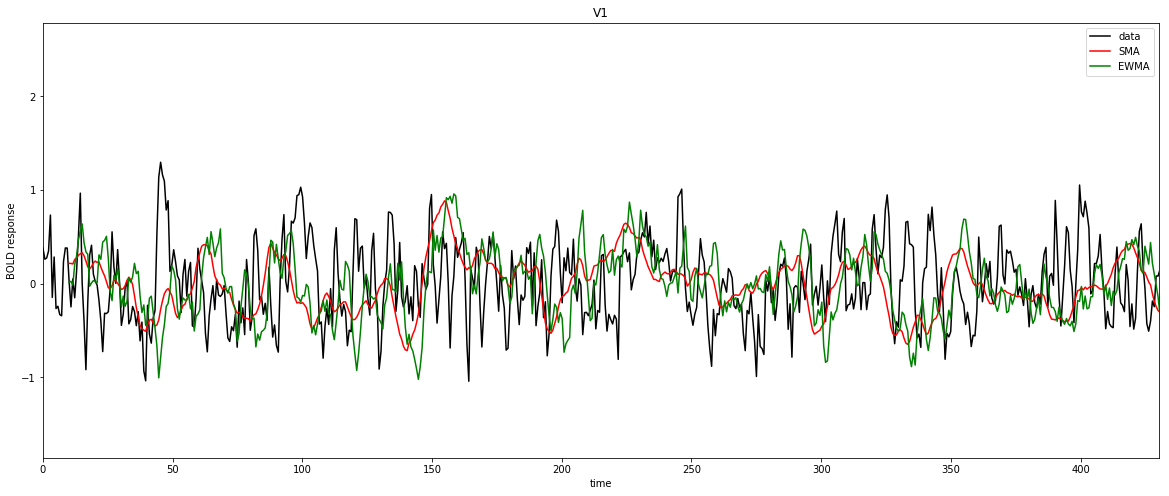

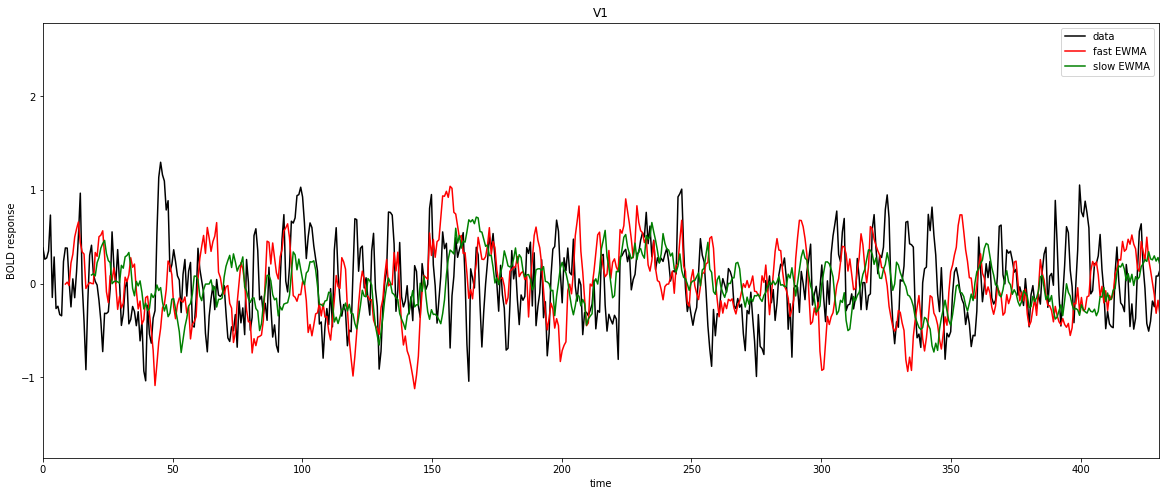

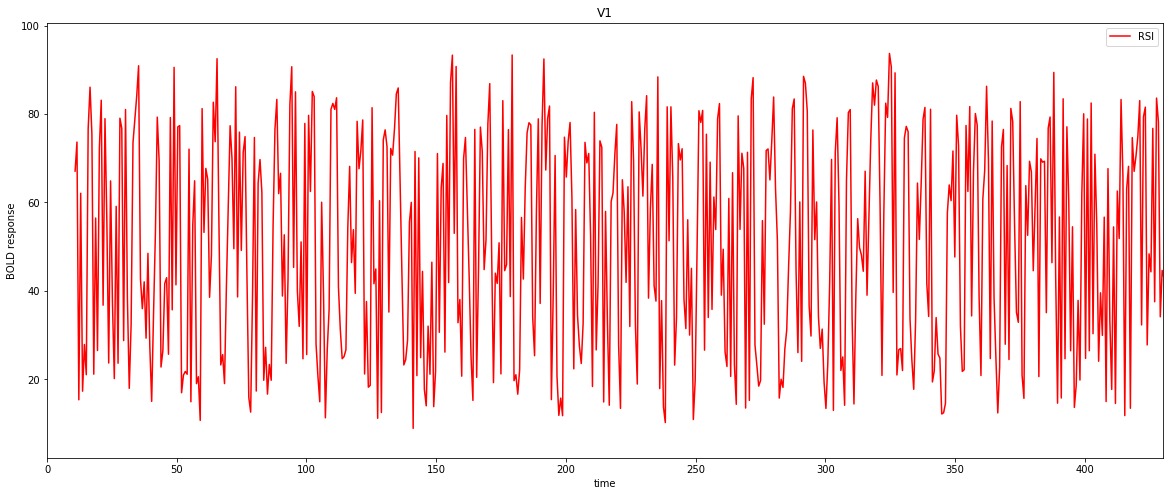

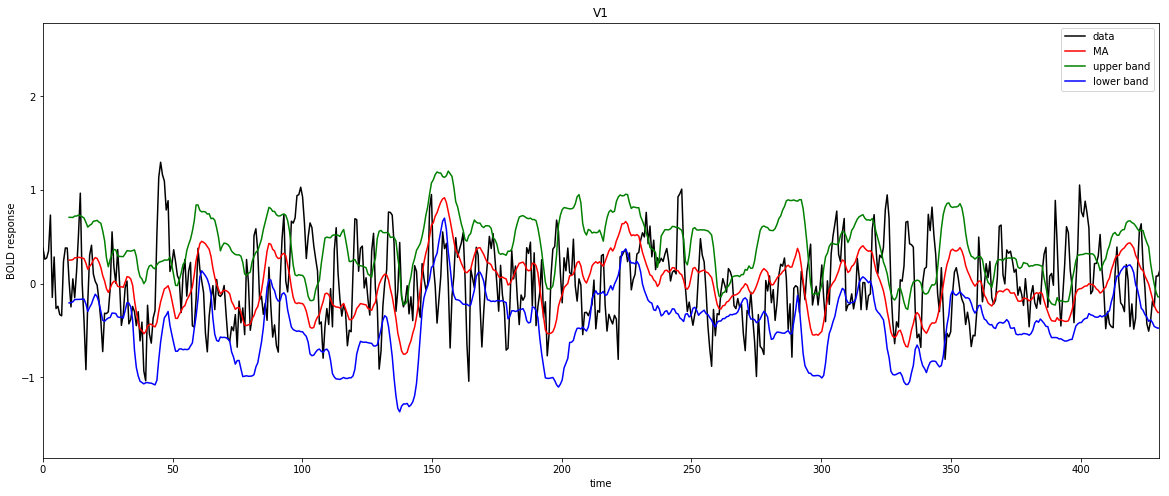

In [8]:
# plot simple and exponential moving average:
plt.figure(figsize=(20,8))
plt.plot(np.arange(N)*TR, x, color='k', label='data')
plt.plot(np.arange(N)[N_SMA:]*TR, SMAvec, color='r', label='SMA')
plt.plot(np.arange(N)[N_EWMA:]*TR, EWMAvec, color='g', label='EWMA')
plt.legend()
plt.xlabel('time')
plt.ylabel('BOLD response')
plt.xlim([0, N*TR*0.25]) #zoom inot first 25% of the chart
plt.title(ROI_name)
plt.show()

# plot MACD:
plt.figure(figsize=(20,8))
plt.plot(np.arange(N)*TR, x, color='k', label='data')
plt.plot(np.arange(N)[N_EWMA1:]*TR, EWMAvec1, color='r', label='fast EWMA')
plt.plot(np.arange(N)[N_EWMA2:]*TR, EWMAvec2, color='g', label='slow EWMA')
plt.legend()
plt.xlabel('time')
plt.ylabel('BOLD response')
plt.xlim([0, N*TR*0.25]) #zoom inot first 25% of the chart
plt.title(ROI_name)
plt.show()

# plot RSI:
plt.figure(figsize=(20,8))
#plt.plot(np.arange(N)*TR, x, color='k', label='data')
plt.plot(np.arange(N)[N_RSI+1:]*TR, RSIvec, color='r', label='RSI')
plt.legend()
plt.xlabel('time')
plt.ylabel('BOLD response')
plt.xlim([0, N*TR*0.25]) #zoom inot first 25% of the chart
plt.title(ROI_name)
plt.show()

# plot Bollinger bands:
plt.figure(figsize=(20,8))
plt.plot(np.arange(N)*TR, x, color='k', label='data')
plt.plot(np.arange(N)[N_BOLL:]*TR, BOLLvec_ma, color='r', label='MA')
plt.plot(np.arange(N)[N_BOLL:]*TR, BOLLvec_upper, color='g', label='upper band')
plt.plot(np.arange(N)[N_BOLL:]*TR, BOLLvec_lower, color='b', label='lower band')
plt.legend()
plt.xlabel('time')
plt.ylabel('BOLD response')
plt.xlim([0, N*TR*0.25]) #zoom inot first 25% of the chart
plt.title(ROI_name)
plt.show()

In [9]:
# In[Data Preperation]
# fill in the 4 parameters:
seq_len             = 22 # the number of past values to predict the future value
future_seq_len      = 10 # the number of future values to predict
predictor_variables = ['V1', 'V2'] # choose predictor variables (list of str)
name_target         = 'V2' # choose which variable you want to predict (str)

sequence_length     = seq_len + future_seq_len 
index_target        = predictor_variables.index(name_target)
data                = df.loc[:,predictor_variables].as_matrix() 
nb_features         = data.shape[1]

print(data.shape)

# chop data into segments:
result = []
for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
    result.append(data[index: index + sequence_length]) # index : index + 22days
result = np.array(result)

# remove the midline (switching from LR to RL encoding):
mid = int(result.shape[0]/2)
result = np.delete(result, range(mid-seq_len, mid+seq_len), axis=0)

print(result.shape)

# split adta into training and testing set:
row = round(0.9 * result.shape[0]) 
X_train = result[:int(row),:-future_seq_len,:] 
y_train = result[:int(row),-future_seq_len:,index_target]  # index_target was =-1 before

X_test = result[int(row):,:-future_seq_len,:]
y_test = result[int(row):,-future_seq_len:,index_target] 

(2390, 2)
(2314, 32, 2)


/scratch/apps/lang/python_gpu/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


In [10]:
X_test.shape

(231, 22, 2)

In [11]:
X_train.shape

(2083, 22, 2)

In [12]:
result[:,-1,:].squeeze().shape

(2314, 2)

In [13]:
# test
mid = int(df.shape[0]/2)
test_ = np.delete(result, range(mid-seq_len, mid+seq_len), axis=0)

data_target_test = df.loc[:, name_target].as_matrix()
data_target_test = data_target_test[:int(round(len(data_target_test)/2))]
data_target_test.shape

/scratch/apps/lang/python_gpu/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


(1195,)

In [14]:
df.shape

(2390, 180)

In [15]:
data.shape

(2390, 2)

In [16]:
# compute autocorrelations in the target node, in order to establish the baseline for prediction:
nsteps_max = future_seq_len # maximum number of steps ahead to make a prediction
def autocorr(x, t=1):
    a = np.corrcoef(np.array([x[0:len(x)-t], x[t:len(x)]]))
    return a

data_target = df.loc[:,name_target].as_matrix()


# shorten data_target to first half of the data in order to avoid the switching from LR to RL encoding problem:
data_target = data_target[:int(round(len(data_target)/2))]

#data_target = result[:,-1,:].squeeze()

baselines = np.zeros((nsteps_max,1))
for ind in range(nsteps_max):
    baselines[ind,0] = autocorr(data_target, t=ind+1)[0,1]

/scratch/apps/lang/python_gpu/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


In [17]:
print(result.shape)

(2314, 32, 2)


In [18]:
print(y_test.shape)

(231, 10)


In [19]:
print(X_test.shape)
print(X_train.shape)

(231, 22, 2)
(2083, 22, 2)


In [20]:
import tensorflow as tf
# In[Model Building]
d = 0.2
shape = [nb_features, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, future_seq_len]

seed_list = [1,2,3,4,5]
prev_steps_list = [i for i in range(1,25)]

res = np.zeros((len(prev_steps_list), len(seed_list), 3), dtype=np.float32)
pred_ahead = np.zeros((len(prev_steps_list), len(seed_list), 10), dtype=np.float32)

for i, seed in enumerate(seed_list):
    for j, n_prev in enumerate(prev_steps_list):
        tf.set_random_seed(seed)
        
        print('Training with random seed {} and {} previous time-steps.\n'.format(seed, n_prev))
        # In[Data Preperation]
        # fill in the 4 parameters:
        seq_len             = n_prev # the number of past values to predict the future value
        future_seq_len      = 10 # the number of future values to predict
        predictor_variables = ['V1', 'V2'] # choose predictor variables (list of str)
        name_target         = 'V2' # choose which variable you want to predict (str)

        sequence_length     = seq_len + future_seq_len 
        index_target        = predictor_variables.index(name_target)
        data                = df.loc[:,predictor_variables].as_matrix() 
        nb_features         = data.shape[1]


        # chop data into segments:
        result = []
        for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
            result.append(data[index: index + sequence_length]) # index : index + 22days
        result = np.array(result)

        # remove the midline (switching from LR to RL encoding):
        mid = int(result.shape[0]/2)
        result = np.delete(result, range(mid-seq_len, mid+seq_len), axis=0)


        # split adta into training and testing set:
        row = round(0.9 * result.shape[0]) 
        X_train = result[:int(row),:-future_seq_len,:] 
        y_train = result[:int(row),-future_seq_len:,index_target]  # index_target was =-1 before

        X_test = result[int(row):,:-future_seq_len,:]
        y_test = result[int(row):,-future_seq_len:,index_target] 

        with tf.device("/gpu:0"):
            model = []
            model = Sequential()
            model.add(LSTM(units=neurons[0], return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
            model.add(Dropout(d))
            model.add(LSTM(neurons[1], return_sequences=False, input_shape=(X_train.shape[1],X_train.shape[2])))
            model.add(Dropout(d))
            model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
            model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
            #model.add(Activation('linear'))
            model.compile(loss='mse', optimizer='rmsprop')
            #model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
            #model.summary()
            # In[Model Fitting]
            model.fit(X_train, y_train, batch_size=512, epochs=50, validation_split=0.1, verbose=0)

        # In[Results]
        trainScore = model.evaluate(X_train, y_train, verbose=0)
        print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))

        testScore = model.evaluate(X_test, y_test, verbose=0)
        print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

        res[j][i][0] = trainScore
        res[j][i][1] = testScore

        from scipy import stats
        from scipy.stats.stats import pearsonr

        prediction = model.predict(X_test)
        prediction = np.squeeze(prediction)

        # summarize the results from deep learning:
        if future_seq_len == 1:
            results_deeplearning = np.zeros((future_seq_len,1))
            for ind in range(future_seq_len):
                results_deeplearning[ind,0] = pearsonr(prediction[:],np.squeeze(y_test[:]))[0]
            print(results_deeplearning)
        else:
            results_deeplearning = np.zeros((future_seq_len,1))
            for ind in range(future_seq_len):
                results_deeplearning[ind,0] = pearsonr(prediction[:,ind],np.squeeze(y_test[:,ind]))[0]
                pred_ahead[j][i][ind] = pearsonr(prediction[:,ind],np.squeeze(y_test[:,ind]))[0]
            print(results_deeplearning)

Training with random seed 1 and 1 previous time-steps.



/scratch/apps/lang/python_gpu/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Train Score: 0.14196 MSE (0.38 RMSE)
Test Score: 0.21173 MSE (0.46 RMSE)
[[ 0.83179655]
 [ 0.64631355]
 [ 0.42356108]
 [ 0.25113206]
 [ 0.18412792]
 [ 0.15102136]
 [ 0.09578147]
 [-0.13651222]
 [-0.11219975]
 [-0.04206251]]
Training with random seed 1 and 2 previous time-steps.

Train Score: 0.14058 MSE (0.37 RMSE)
Test Score: 0.21033 MSE (0.46 RMSE)
[[ 0.84548304]
 [ 0.68699404]
 [ 0.46999378]
 [ 0.26268649]
 [ 0.17188262]
 [ 0.0990002 ]
 [ 0.11787726]
 [-0.10095608]
 [-0.10071933]
 [-0.07664724]]
Training with random seed 1 and 3 previous time-steps.

Train Score: 0.13995 MSE (0.37 RMSE)
Test Score: 0.21091 MSE (0.46 RMSE)
[[ 0.84524463]
 [ 0.67825136]
 [ 0.45927748]
 [ 0.2545747 ]
 [ 0.15812123]
 [ 0.09787754]
 [ 0.06526077]
 [-0.07240472]
 [-0.09980815]
 [-0.07633485]]
Training with random seed 1 and 4 previous time-steps.

Train Score: 0.13995 MSE (0.37 RMSE)
Test Score: 0.21257 MSE (0.46 RMSE)
[[ 0.84313787]
 [ 0.68562515]
 [ 0.45911899]
 [ 0.24412571]
 [ 0.13887082]
 [ 0.0797237

Train Score: 0.13907 MSE (0.37 RMSE)
Test Score: 0.21399 MSE (0.46 RMSE)
[[ 0.83710228]
 [ 0.6771753 ]
 [ 0.45178929]
 [ 0.2439702 ]
 [ 0.13652174]
 [ 0.02193817]
 [-0.02729359]
 [-0.05392803]
 [ 0.01200574]
 [ 0.09811071]]
Training with random seed 2 and 8 previous time-steps.

Train Score: 0.13938 MSE (0.37 RMSE)
Test Score: 0.21444 MSE (0.46 RMSE)
[[0.81848772]
 [0.63942114]
 [0.41865941]
 [0.20487205]
 [0.08390933]
 [0.03293079]
 [0.02087027]
 [0.0452318 ]
 [0.10456856]
 [0.18312565]]
Training with random seed 2 and 9 previous time-steps.

Train Score: 0.13804 MSE (0.37 RMSE)
Test Score: 0.21095 MSE (0.46 RMSE)
[[0.83214945]
 [0.66193245]
 [0.42102403]
 [0.20847894]
 [0.1036927 ]
 [0.08931742]
 [0.11154762]
 [0.13935173]
 [0.20095797]
 [0.26251844]]
Training with random seed 2 and 10 previous time-steps.

Train Score: 0.13918 MSE (0.37 RMSE)
Test Score: 0.20990 MSE (0.46 RMSE)
[[0.82502023]
 [0.6384292 ]
 [0.41426508]
 [0.22528174]
 [0.15313725]
 [0.13993147]
 [0.19157753]
 [0.2116

Train Score: 0.13737 MSE (0.37 RMSE)
Test Score: 0.20333 MSE (0.45 RMSE)
[[0.81940537]
 [0.66003   ]
 [0.46036899]
 [0.32709327]
 [0.30493133]
 [0.33392208]
 [0.35974617]
 [0.32765274]
 [0.30392653]
 [0.29282406]]
Training with random seed 3 and 14 previous time-steps.

Train Score: 0.13765 MSE (0.37 RMSE)
Test Score: 0.20343 MSE (0.45 RMSE)
[[0.82029467]
 [0.65322501]
 [0.47268588]
 [0.33653806]
 [0.31401461]
 [0.32205041]
 [0.33481008]
 [0.2825018 ]
 [0.28075095]
 [0.27300517]]
Training with random seed 3 and 15 previous time-steps.

Train Score: 0.13733 MSE (0.37 RMSE)
Test Score: 0.20429 MSE (0.45 RMSE)
[[0.82439603]
 [0.65964611]
 [0.48756279]
 [0.36088018]
 [0.32859255]
 [0.33321007]
 [0.31627087]
 [0.26656307]
 [0.22132871]
 [0.23141627]]
Training with random seed 3 and 16 previous time-steps.

Train Score: 0.13800 MSE (0.37 RMSE)
Test Score: 0.20796 MSE (0.46 RMSE)
[[0.81902103]
 [0.65386637]
 [0.49031341]
 [0.36611194]
 [0.33716736]
 [0.33934987]
 [0.28709815]
 [0.20586539]
 [

[[0.82838594]
 [0.68800236]
 [0.52277957]
 [0.35589191]
 [0.27801837]
 [0.22112709]
 [0.2280374 ]
 [0.19462754]
 [0.21971107]
 [0.24625176]]
Training with random seed 4 and 20 previous time-steps.

Train Score: 0.13411 MSE (0.37 RMSE)
Test Score: 0.21838 MSE (0.47 RMSE)
[[0.7958305 ]
 [0.62135387]
 [0.39939441]
 [0.23740457]
 [0.15422894]
 [0.13388338]
 [0.14411637]
 [0.14165063]
 [0.15555204]
 [0.18360167]]
Training with random seed 4 and 21 previous time-steps.

Train Score: 0.13385 MSE (0.37 RMSE)
Test Score: 0.21309 MSE (0.46 RMSE)
[[0.81331799]
 [0.64920305]
 [0.44791437]
 [0.27373243]
 [0.18800038]
 [0.15934683]
 [0.14426452]
 [0.14682496]
 [0.17876126]
 [0.21700861]]
Training with random seed 4 and 22 previous time-steps.

Train Score: 0.13211 MSE (0.36 RMSE)
Test Score: 0.20267 MSE (0.45 RMSE)
[[0.82500396]
 [0.68761694]
 [0.51268416]
 [0.35144598]
 [0.29757526]
 [0.27297681]
 [0.26834049]
 [0.27154221]
 [0.28582547]
 [0.26201476]]
Training with random seed 4 and 23 previous ti

In [26]:
df_res_train = pd.DataFrame(0, index=prev_steps_list, columns=seed_list)
df_res_test = df_res_train.copy()

In [34]:
avg = pred_ahead.mean(axis=1).squeeze()

In [36]:
df_pred_ahead = pd.DataFrame(0, index=prev_steps_list, columns=[i for i in range(future_seq_len)])

In [39]:
for i, prev in enumerate(prev_steps_list):
    for j, step_ahead in enumerate([i for i in range(future_seq_len)]):
        df_pred_ahead.iloc[i, j] = avg[i, j]

In [40]:
df_pred_ahead

,0,1,2,3,4,5,6,7,8,9
1,0.831439,0.645432,0.423044,0.252329,0.183344,0.148635,0.101891,-0.143268,-0.107569,-0.040611
2,0.845740,0.682907,0.464163,0.264831,0.173178,0.110660,0.092083,-0.115914,-0.112301,-0.076018
3,0.844960,0.678979,0.460060,0.256710,0.162313,0.088252,0.050049,-0.075769,-0.101986,-0.071651
4,0.844772,0.682318,0.462515,0.257882,0.158580,0.084200,0.026582,-0.103097,-0.123613,-0.077608
5,0.843689,0.684966,0.470420,0.257047,0.146483,0.062323,-0.021327,-0.113033,-0.108250,-0.041742
6,0.840261,0.677607,0.453616,0.252998,0.136841,0.042122,-0.034507,-0.103998,-0.061180,0.028691
7,0.835875,0.672894,0.442580,0.230294,0.120809,0.009444,-0.020335,-0.050181,0.011950,0.102695
8,0.826687,0.659549,0.431096,0.224253,0.087209,0.013777,0.013274,0.022496,0.102466,0.191981
9,0.828179,0.659243,0.423633,0.205103,0.097938,0.063085,0.088579,0.116147,0.185984,0.264532
10,0.822180,0.641977,0.402891,0.201932,0.130892,0.131443,0.179672,0.209963,0.249538,0.284333


In [43]:
pred_ahead.mean(axis=1).shape

(24, 10)

In [62]:
xyz=np.array(np.random.random((100,3)))
xyz.shape

(100, 3)

In [67]:
x=xyz[:,0]
y=xyz[:,1]
z=xyz[:,2]*100

In [77]:
ny, nx = pred_ahead.mean(axis=1).shape
x = np.arange(1, nx+1)
y = np.arange(1, ny+1)
xv, yv = np.meshgrid(x, y)

In [78]:
pred_ahead.mean(axis=1).shape

(24, 10)

In [1]:
fig = plt.figure()#figsize=(900,600))
ax = fig.add_subplot(111, projection='3d')
dem3d=ax.plot_surface(xv,yv,pred_ahead.mean(axis=1))
plt.show()

NameError: name 'plt' is not defined

(40,)
(40, 40)
(40, 40)


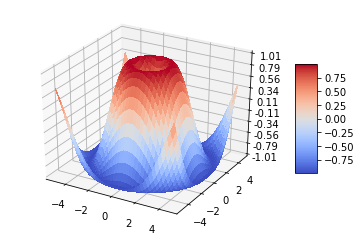

In [61]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
print(X.shape)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)
print(Y.shape)
print(Z.shape)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [28]:
for i, seed in enumerate(seed_list):
    for j, n_prev in enumerate(prev_steps_list):
        df_res_train.iloc[j, i] = res[j,i,0]
        df_res_test.iloc[j, i] = res[j,i,1]

In [32]:
df_res_test.T.mean()

1     0.211037
2     0.209945
3     0.210817
4     0.211148
5     0.211952
6     0.213442
7     0.214419
8     0.214283
9     0.211977
10    0.210985
11    0.207456
12    0.206416
13    0.204343
14    0.203766
15    0.206306
16    0.208005
17    0.206305
18    0.209267
19    0.210605
20    0.213873
21    0.213185
22    0.214656
23    0.213231
24    0.217754
dtype: float64

In [58]:
# summarize the results from deep learning:
if future_seq_len == 1:
    results_deeplearning = np.zeros((future_seq_len,1))
    for ind in range(future_seq_len):
        results_deeplearning[ind,0] = pearsonr(prediction[:],np.squeeze(y_test[:]))[0]
    print(results_deeplearning)
else:
    results_deeplearning = np.zeros((future_seq_len,1))
    for ind in range(future_seq_len):
        results_deeplearning[ind,0] = pearsonr(prediction[:,ind],np.squeeze(y_test[:,ind]))[0]
    print(results_deeplearning)

[[0.82076212]
 [0.64883521]
 [0.442869  ]
 [0.26503085]
 [0.16744218]
 [0.13604571]
 [0.14545685]
 [0.16505448]
 [0.18028406]
 [0.17837866]]


In [69]:
results_deeplearning.shape

(10, 1)

In [59]:
# compare with baseline:
print(baselines)

[[ 0.75313134]
 [ 0.51559211]
 [ 0.31345645]
 [ 0.2005305 ]
 [ 0.11339312]
 [ 0.05606893]
 [ 0.02904786]
 [ 0.03077386]
 [ 0.00763259]
 [-0.01135883]]


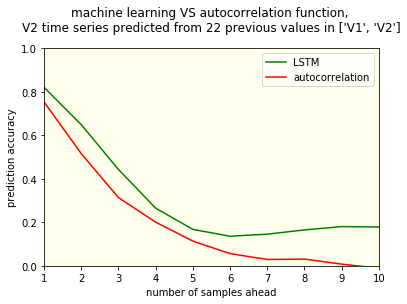

In [60]:
# plot the results:
fig = plt.figure()

ax = plt.gca()
ax.set_facecolor((1,1,235/255))

x = np.arange(future_seq_len)
labels = np.ndarray.tolist(x + 1)
plt.xticks(x, labels)
plt.plot(x, results_deeplearning[:,0], 'g', label = 'LSTM')
plt.plot(x, baselines[:,0], 'r', label = 'autocorrelation')
plt.xlim([0,future_seq_len - 1])
plt.ylim([0,1])
plt.xlabel('number of samples ahead')
plt.ylabel('pearson r')

plt.title('machine learning VS autocorrelation function, ' + '\n' + name_target  + \
          ' time series predicted from ' + str(seq_len) + ' previous values in ' + str(predictor_variables), y=1.05)
plt.legend()
plt.show()

In [63]:
!pwd

/scratch/home/g.koehler/test_keras/BrainhackNetworks_indicators_restingstate/codes


In [64]:
# save the plot:
filename = 'MLvsAUTOCORR_target' + name_target + '_predictors' + str(predictor_variables) + \
'_subject' + str(subject_label) + '_day' + str(day_num)


folder_output = '/scratch/home/g.koehler/test_keras/BrainhackNetworks_indicators_restingstate/results/'
fname = folder_output + filename

dpis = [300, 600]
formats = ['jpg', 'png', 'pdf']

hp.savef(fig, fname, dpis, formats)

In [65]:
!ls ../results/

1.txt
MLvsAUTOCORR_targetV2_predictors['V1', 'V2']_subject100307_day1_300dpi.jpg
MLvsAUTOCORR_targetV2_predictors['V1', 'V2']_subject100307_day1_300dpi.pdf
MLvsAUTOCORR_targetV2_predictors['V1', 'V2']_subject100307_day1_300dpi.png
MLvsAUTOCORR_targetV2_predictors['V1', 'V2']_subject100307_day1_600dpi.jpg
MLvsAUTOCORR_targetV2_predictors['V1', 'V2']_subject100307_day1_600dpi.pdf
MLvsAUTOCORR_targetV2_predictors['V1', 'V2']_subject100307_day1_600dpi.png
mse_results_test.csv
mse_results_train.csv
results_predict_1.ipynb


In [66]:
# run autoregressive model:

In [68]:
from pandas import Series
from matplotlib import pyplot

import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR

print(data.shape)
model = VAR(data)
results = model.fit(22)
results.summary()

lag_order = results.k_ar
results.forecast(data[-lag_order:], 5)

(2390, 2)


array([[0.34413325, 0.31096335],
       [0.31311591, 0.26267158],
       [0.20515005, 0.21638101],
       [0.12073263, 0.12567879],
       [0.06979601, 0.04589109]])